In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')

#    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [3]:
df = pd.read_csv("creditcard.csv")
print(df.head(3))
y = np.array(df.Class.tolist())     #classes: 1..fraud, 0..no fraud
df = df.drop('Class', 1)
df = df.drop('Time', 1)     # optional
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))    #optionally rescale non-normalized column
X = np.array(df.as_matrix())   # features

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys




A class of 0 means that the transaction was in order, and a class of 1 means that the transaction was fraudulent.We expect frauds to make up only a tiny fraction of all transactions. Indeed, in this dataset, for every fraud there are almost 600 non-fraudulent transactions:


In [4]:


print("Fraction of frauds: {:.5f}".format(np.sum(y)/len(y)))



Fraction of frauds: 0.00173




Since the classes are highly imbalanced, we need to consider an appropriate measure for the quality of a fraud detection method. If we would naively count the fraction of classes we got right (i.e. correctly predicted 0 or 1), already the simple model that always predicts 0 (non-fraud) would achieve an "accuracy" of 99.827%, since only frauds are not recognized correctly, and they are obviously rare. However, such a model is not efficient, since it cannot tell us whether a given transaction is a fraud or not. And the extremely high accuracy is misleading, and does not tell us anything about the actual quality of the prediction. Hence, we need a more sophisticated approach to evaluate a prediction. Let us illustrate this with a simple Logistic Regression

We split the data into a training set and a test set. StratifiedKFold takes the ratio of fraud/non-fraud into account, which is important for such an imbalanced set.


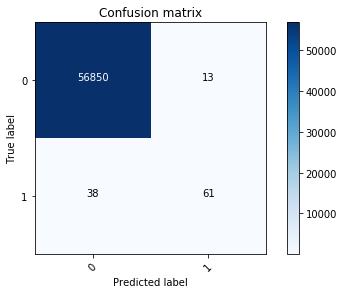

Precision =     0.824
Recall (TPR) =  0.616
Fallout (FPR) = 2.286e-04


In [5]:


lrn = LogisticRegression()

skf = StratifiedKFold(n_splits = 5, shuffle = True)
for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    break

lrn.fit(X_train, y_train)
y_pred = lrn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);





We have split the data into a training and a testing set at a ratio of 4:1, trained a Logistic Regression on the training set, and predicted the outcome on the testing set. The result of this prediction is depicted in the confusion matrix. We can see that almost all non-fraudulent transactions are also recognized as such. About 2/3 of all frauds are detected, but quite many are not recognized. The confusion matrix is a convenient way of illustrating the behavior of a classifier.

    The Precision denotes the probability that a transaction that is classified as fraud is truly a fraud.
    The Recall (aka. True Positive Rate) is the probability that a true fraud is recognized by the classifier.
    The Fallout (aka. False Positive Rate) is the probability that a non-fraud is wrongly classified as a fraud.

These numbers provide a more tangible characterization of a classifier. When tuning the parameters for a classifier, we need to ask ourselves what we expect of a "good" classifier.

    The Precision should be large (close to 1). A precision close to 0 means that a fraud alert will turn out as a mistake in the majority of the cases.
    The Recall should be close to 1. We want to detect frauds with a high probability. A recall of ~60% like for the classifier above is certainly not good enough - many frauds will go undetected. We definitly aim for something higher, 80% would be quite good! (Note that since frauds are often non-singular events on an account, it can be good enough to detect at least one out of two frauds - with a Recall of 80% this means that the probability that two consecutive frauds go undetected is as low as 4% already!)
    The Fallout should be very low. We speculate that a Fallout less than 0.1% would be adequate - for an average daily number of 3 transactions this would result in 1 wrong alert per year. Here we will actually aim for the even better fallout <3e-4.

### Parameter Tuning

The parameters we want to optimize are C in the logistic regression, the class weight, and the probability threshold: The logistic regression returns probabilities for the predicted classes, and the prediction is usually based on whether a probability is above a certain threshold or not. By changing the threshold, we can make our model more sensitive (but also increase wrong detections), or less strict (and miss more frauds).

A canonical approach for our problem would be the ROC-curve, which plots the Recall vs. the Fallout for varying thresholds. Recall and Fallout are precisely the quantities we are interested of. It will not tell us which threshold is suitable, but it will help us find the optimal C.

We will determine the ROC-curve from repeating the StratifiedKFold splitting several times, and taking the mean, in order to eliminate noise. The logistic regression can take imbalanced classes into account, using the option class_weight. The parameter r gives a weight to the underrepresented class 1: r=1 gives class 1 a weight inversely proportional to its occurence, which is actually recommended. The bigger r is chosen, the less weight is given to class 1 (see the specification in dic_weight below).

The following function creates the data for the ROC-curve through repeating StratifiedKFold:


In [6]:
def ROC(X, y, c, r):
#makes cross_validation for given parameters c,r. Returns FPR, TPR (averaged)
    dic_weight = {1:len(y)/(r*np.sum(y)), 0:len(y)/(len(y)-r*np.sum(y))} 
    lrn = LogisticRegression(penalty = 'l2', C = c, class_weight = dic_weight)
    
    N = 5      #how much k-fold
    N_iter = 3    #repeat how often (taking the mean)
    mean_tpr = 0.0
    mean_thresh = 0.0
    mean_fpr = np.linspace(0, 1, 50000)
    

    for it in range(N_iter):
        skf = StratifiedKFold(n_splits = N, shuffle = True)
        for train_index, test_index in skf.split(X, y):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]
         
            lrn.fit(X_train, y_train)
            y_prob = lrn.predict_proba(X_test)[:,lrn.classes_[1]]
            
            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            mean_tpr += np.interp(mean_fpr, fpr, tpr)
            mean_thresh += np.interp(mean_fpr, fpr, thresholds)
            mean_tpr[0] = 0.0

    mean_tpr /= (N*N_iter)
    mean_thresh /= (N*N_iter)
    mean_tpr[-1] = 1.0
    return mean_fpr, mean_tpr, roc_auc_score(y_test, y_prob), mean_thresh



The following plots the ROC-curve for different parameters:


In [7]:
def plot_roc(X,y, list_par_1, par_1 = 'C', par_2 = 1):

    f = plt.figure(figsize = (12,8));
    for p in list_par_1:
        if par_1 == 'C':
            c = p
            r = par_2
        else:
            r = p
            c = par_2
        list_FP, list_TP, AUC, mean_thresh = ROC(X, y, c, r)      
        plt.plot(list_FP, list_TP, label = 'C = {}, r = {}, TPR(3e-4) = {:.4f}, AUC = {:.4f}'.format(c,r,list_TP[10],AUC));
    plt.legend(title = 'values', loc='lower right')
    plt.xlim(0, 0.001)   #we are only interested in small values of FPR
    plt.ylim(0.5, 0.9)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC detail')
    plt.axvline(3e-4, color='b', linestyle='dashed', linewidth=2)
    plt.show()
   

We will now perform a grid search, in order to find quasi-optimal parameters C and r. Say that we want a Fallout < 3e-4. Our goal is to maximize TPR for FPR = 3e-4 (see the dotted vertical line). Let us first look at the influence of the class weight parameter r (since only r = 1 correctly represents the class weights, we somehow expect to find r = 1 confirmed):

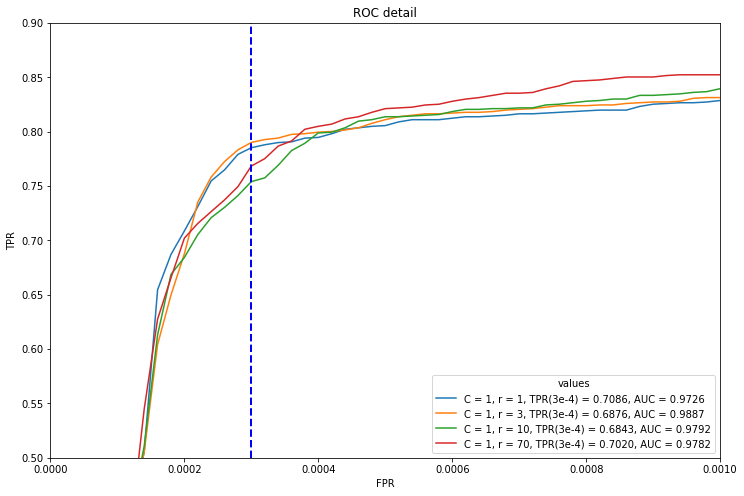

In [8]:


plot_roc(X,y, [1,3,10,70], 'r', 1)





Especially the very small C = 0.001 stands out with significantly poorer performance. For all larger values the model performs similarly well, and we pick C = 1 for our final model.
### Validation of the final model

As we will see soon, it is a probability threshold very close to 1 yields the desired result. We will now repeat the StratifiedKFold for the final model, and plot TPR and FPR as functions of the threshold, so that we can choose the right threshold.


In [9]:
N = np.arange(10,80,2)     # will define threshold
cm = {}     #will store the confusion matrix for different thresholds
for n in N:
    cm[n] = 0.0
lrn = LogisticRegression(penalty = 'l2', C = 1, class_weight = 'balanced')   #'balanced' corresponds to the case r=1
N_Kfold = 5      #how much k-fold
N_iter = 3   #repeat how often (taking the mean)
for it in range(N_iter):
    skf = StratifiedKFold(n_splits = N_Kfold, shuffle = True)
    for train_index, test_index in skf.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        lrn.fit(X_train, y_train)
        y_prob = lrn.predict_proba(X_test)[:,lrn.classes_[1]]
        
        for n in N:
            thresh = 1 - np.power(10.,-(n/10))  #we want thresholds very close to 1
            # generate the prediction from the probabilities y_prob:
            y_pred = np.zeros(len(y_prob))
            for j in range(len(y_prob)):
                if y_prob[j] > thresh:
                    y_pred[j] = 1
    
            B = confusion_matrix(y_test, y_pred)
            #if the classes are mixed up, remedy that:
            if lrn.classes_[0] == 1:
                B = np.array([[B[1,1], B[1,0]], [B[0,1], B[0,0]]])
            cm[n]+=B
#finally, normalize the confusion matrices:
for n in N:
    cm[n] = cm[n]//(N_Kfold*N_iter)



We have now averaged confusion matrices for different thresholds, stored in cm. We extract TPR and FPR from the matrices, and plot them:


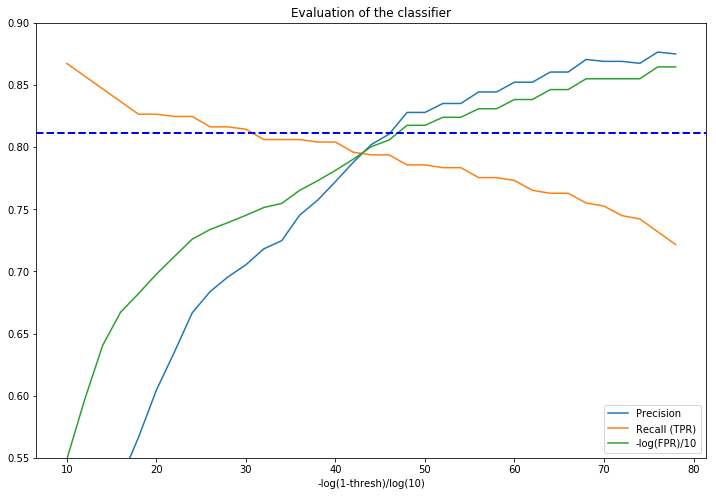

In [10]:
PR = []      #precision
TPR = []
FPR = []
THRESH = N
for n in N:
    pr, tpr, fpr = show_data(cm[n])
    PR.append(pr)
    TPR.append(tpr)
    FPR.append(-np.log(fpr)/10)

g  = plt.figure(figsize = (12,8))   
plt.plot(THRESH, PR, label = 'Precision')
plt.plot(THRESH, TPR, label = 'Recall (TPR)')
plt.plot(THRESH, FPR, label = '-log(FPR)/10')
plt.axhline(-np.log(3e-4)/10, color='b', linestyle='dashed', linewidth=2)
plt.title('Evaluation of the classifier')
plt.legend( loc='lower right')
plt.xlabel('-log(1-thresh)/log(10)')
plt.ylim(0.55,0.9)
plt.show()



If we want a Fallout < 3e-4 we are only interested in data right of the intersection of the dotted line and the FPR-curve. We compute Recall, Fallout and Precision for the corresponding threshold:


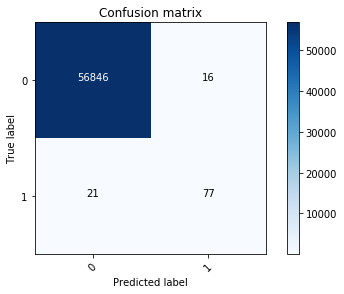

Precision =     0.828
Recall (TPR) =  0.786
Fallout (FPR) = 2.814e-04


In [11]:


i = 0
while FPR[i] < -np.log(3e-4)/10:
    i+=1
A = cm[THRESH[i]].astype(int)
plot_confusion_matrix(A, ['0', '1'])
show_data(A, print_res = 1);





To some extent we can use this model for different thresholds, or FPR, respectively. Only for FPR > 4e-4 the above cross-validation would need to be redone.Now, we relax the FPR-requirement:


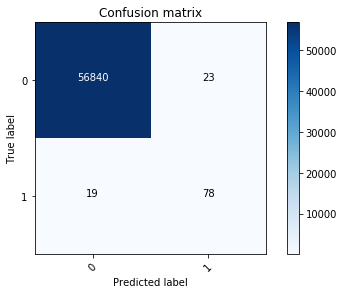

Precision =     0.772
Recall (TPR) =  0.804
Fallout (FPR) = 4.045e-04


In [12]:


i = 0
while FPR[i] < -np.log(4.1e-4)/10:
    i+=1
A = cm[THRESH[i]].astype(int)
plot_confusion_matrix(A, ['0', '1'])
show_data(A, print_res = 1);





This is not really an improvement - in particular the Recall did not improve significantly, only the Fallout got worse. This is not desirable. Let us also look at a smaller FPR of 2e-4:


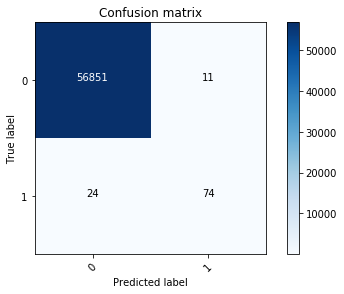

Precision =     0.871
Recall (TPR) =  0.755
Fallout (FPR) = 1.935e-04


In [13]:
i = 0
while FPR[i] < -np.log(2e-4)/10:
    i+=1
A = cm[THRESH[i]].astype(int)
plot_confusion_matrix(A, ['0', '1'])
show_data(A, print_res = 1);



In the end we think that that a fallout between 2e-4 and 3e-4 is reasonabe. The expected recall then lies between 75% and 80%. The final choice might depend on practical considerations, based on data not available here (e.g. what are the costs for the bank of a false alert vs a not detected fraud). Similarly to the approach taken here, one could also fix a Recall and then minimize the Fallout. However, the above analysis indicates that the ROC-curve flattens out significantly for FPR > 4e-4, and a Recall over 80% is extremely hard to achieve - and then only in combination with a drastic increase of the Fallout, for example:


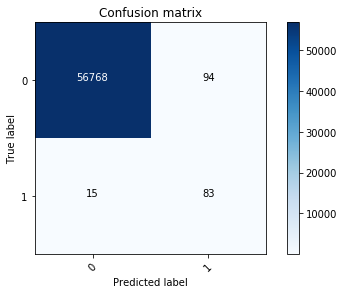

Precision =     0.469
Recall (TPR) =  0.847
Fallout (FPR) = 1.653e-03


In [14]:
i = 0
while FPR[i] < -np.log(2e-3)/10:
    i+=1
A = cm[THRESH[i]].astype(int)
plot_confusion_matrix(A, ['0', '1'])
show_data(A, print_res = 1);


### Conclusion

We have found that for a Fallout of 0.03% we can obtain a Recall of roughly 80%. Any significant improvement of the Recall comes with very high cost for the Fallout. Similarly, any substantial improvement of the Fallout will drastically reduce the Fallout.


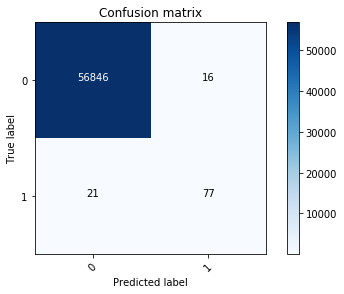

Precision =     0.828
Recall (TPR) =  0.786
Fallout (FPR) = 2.814e-04


In [15]:


i = 0
while FPR[i] < -np.log(3e-4)/10:
    i+=1
A = cm[THRESH[i]].astype(int)
plot_confusion_matrix(A, ['0', '1'])
show_data(A, print_res = 1);

